# Predictive Task
We will attempt to classify hand written digits from MNIST dataset using Multilayer Perceptron (MLP) Model

# Reading Dataset 
MNIST is already present in tensorflow. We read dataset using one hot encoding

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data", one_hot=True )

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data\t10k-labels-idx1-ubyte.gz


### We can see that the dataset contains -
* Train, test and Validation sets
* The Training set is made up of images and labels
* Images is modelled as a vector of length 784
* We see one training X vector
* Similarly we can see that the labels are one hot encoded vector of lenght 10 representing each of the 10 possible digits
* We see one training y label

In [13]:
print( dir( mnist )[-3:] )
print( dir( mnist.train )[-5:] )
print( len( mnist.train.images[0] ) )
print( mnist.train.images[:10 ] )
print( len( mnist.train.labels[0] ) )
print( mnist.train.labels[0] )

['test', 'train', 'validation']
['epochs_completed', 'images', 'labels', 'next_batch', 'num_examples']
784
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
10
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


### We shall try plotting an input image

In [14]:
sample_image = mnist.train.images[0].reshape( [ 28, 28 ] )

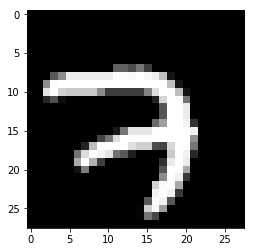

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.gray()
plt.imshow( sample_image )

# Hyper Parameters
Define the configuration for the model

In [28]:
learning_rate = 0.01
num_steps = 100
batch_size = 128
display_step = 1

In [18]:
n_hidden_1 = 300
n_hidden_2 = 300
num_input = 784
num_classes = 10

In [19]:
checkpoint_every = 100
checkpoint_dir = './runs/'

# Model
* Import Tensorflow
* Implement Placeholder constraints defining size of input vector and number of label classes

In [20]:
import tensorflow as tf

In [21]:
X = tf.placeholder( "float", [None, num_input], name="input_x")
Y = tf.placeholder( "float", [None, num_classes], name="input_y")

Initialize the weights and bias vectors with random normal distribution

In [23]:
weights = \
{
    'h1' : tf.Variable( tf.random_normal( [ num_input, n_hidden_1 ] ) ),
    'h2' : tf.Variable( tf.random_normal( [ n_hidden_1, n_hidden_2 ] ) ),
    'out' : tf.Variable( tf.random_normal( [ n_hidden_2, num_classes ] ) )
}

In [24]:
biases = \
{
    'b1' : tf.Variable( tf.random_normal( [ n_hidden_1 ] ) ),
    'b2' : tf.Variable( tf.random_normal( [ n_hidden_2 ] ) ),
    'out' : tf.Variable( tf.random_normal( [ num_classes ] ) )
}

Setting up the logistic regression operation

In [25]:
layer_1 = tf.add( tf.matmul( X, weights['h1'] ), biases['b1'] )
layer_2 = tf.add( tf.matmul( layer_1, weights['h2'] ), biases['b2'] )
logits = tf.add( tf.matmul( layer_2, weights['out'] ), biases['out'] )

Convert the logistic values into probabilistic values. Thus, output values will be between zero and one.

In [32]:
prediction = tf.nn.softmax( logits, name='prediction' )

* Cost function is cross entropy with logits
* Optimizer is Adam Optimizer
* It will use the minimuze function to come up with the SGD update rule for parameters

In [33]:
loss_op = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2( logits = logits, labels = Y ) )
optimizer = tf.train.AdamOptimizer( learning_rate = learning_rate )
train_op = optimizer.minimize( loss_op )

Now we make the predictions and check for accuracy

In [34]:
correct_pred = tf.equal( tf.argmax( prediction, 1 ), tf.argmax( Y, 1 ) )
accuracy = tf.reduce_mean( tf.cast( correct_pred, tf.float32 ) )

# Training
* Set up a checkpoint directory to record the intermediate results
* Create a tensorflow session
* Feed appropriate values to the model and train

In [35]:
import os
checkpoint_dir = os.path.abspath( os.path.join( checkpoint_dir, "checkpoints") )
checkpoint_prefix = os.path.join( checkpoint_dir, "model" )
if not os.path.exists( checkpoint_dir ):
    os.makedirs( checkpoint_dir )

In [51]:
saver = tf.train.Saver( tf.global_variables(), max_to_keep = 2 )
init = tf.global_variables_initializer()
all_loss = []
preds = []

In [73]:
with tf.Session() as sess:
    writer_1 = tf.summary.FileWriter( "./runs/summary", sess.graph )
    sum_var = tf.summary.scalar( "loss", accuracy )
    write_op = tf.summary.merge_all()
    
    sess.run( init )
    
    for step in range( 1, num_steps + 1 ):
        batch_x, batch_y = mnist.train.next_batch( batch_size )
        sess.run( train_op, feed_dict = { X : batch_x, Y : batch_y } )
        if step % display_step == 0 or step == 1:
            loss, acc, summary = sess.run( [ loss_op, accuracy, write_op ], feed_dict = { X : batch_x, Y : batch_y } )
            all_loss.append( loss )
            writer_1.add_summary( summary, step )
            print( "Step " + str( step ) + ", Minibatch Loss = " + \
                 "{:.4f}".format( loss ) + ", Training Accuracy = " + \
                 "{:.3f}".format( acc ) )
        
        if step % checkpoint_every == 0:
            path = saver.save( sess, checkpoint_prefix, global_step = step )
            
    print( "Optimization Finished " )
    
    print( "Testing Accuracy:",\
          sess.run( accuracy, feed_dict = { X : mnist.test.images, Y : mnist.test.labels } ) )
    
    for p in sess.run( prediction, feed_dict={ X: mnist.test.images[ :24 ] } ):
        preds.append( p.tolist().index( float(1) ) )
            

Step 1, Minibatch Loss = 2201.3198, Training Accuracy = 0.289
Step 2, Minibatch Loss = 1854.9180, Training Accuracy = 0.305
Step 3, Minibatch Loss = 1104.8843, Training Accuracy = 0.461
Step 4, Minibatch Loss = 750.2520, Training Accuracy = 0.539
Step 5, Minibatch Loss = 760.5498, Training Accuracy = 0.578
Step 6, Minibatch Loss = 754.6323, Training Accuracy = 0.656
Step 7, Minibatch Loss = 854.0834, Training Accuracy = 0.633
Step 8, Minibatch Loss = 655.5831, Training Accuracy = 0.688
Step 9, Minibatch Loss = 764.5542, Training Accuracy = 0.609
Step 10, Minibatch Loss = 388.5724, Training Accuracy = 0.734
Step 11, Minibatch Loss = 652.9672, Training Accuracy = 0.695
Step 12, Minibatch Loss = 406.4876, Training Accuracy = 0.766
Step 13, Minibatch Loss = 353.7976, Training Accuracy = 0.789
Step 14, Minibatch Loss = 483.9919, Training Accuracy = 0.750
Step 15, Minibatch Loss = 484.1235, Training Accuracy = 0.820
Step 16, Minibatch Loss = 586.9910, Training Accuracy = 0.805
Step 17, Minib

# Notes
* We see that training loss decreases overall as steps increase.
* In this case, we can improve regularization using L1 or L2 norms at layers L1 or L2.
* Additionally, we can now use the saver to train from the model checkpoint and use it to test on the test data

# Interpreting Results
Compare labels to predictions from MLP model

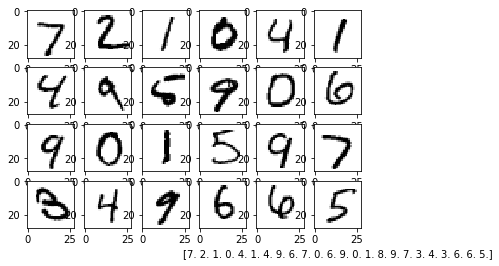

In [78]:
#https://stackoverflow.com/questions/37228371/visualize-mnist-dataset-using-opencv-or-matplotlib-pyplot
import numpy as np
amount = 24
lines = 4
columns = 6
image = np.zeros((amount, 28, 28))
number = np.zeros(amount)

for i in range(amount):
    image[i] = mnist.test.images[ i ].reshape(28, 28)
    number[i] = preds[ i ]

fig = plt.figure()

for i in range(amount):
    ax = fig.add_subplot(lines, columns, 1 + i)
    plt.imshow(image[i], cmap='binary')
    plt.sca(ax)

plt.xlabel(number)
plt.show()

References

https://github.com/PacktPublishing/Python-Deep-Learning